In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from wordcloud import WordCloud, ImageColorGenerator
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from PIL import Image
import random

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
base_path = '/content/gdrive/MyDrive/Service Science - PROGETTO'

In [4]:
df = pd.read_csv(f"{base_path}/dati/attiv_stor_milano.csv", encoding="utf-8")
df

,ID_NLS,TIPO,RIC,PR,COMUNE,INDIR_ORIG,ZIP,ISTAT,DENOM_IMPRES,INSEGNA,INIZIO_ATT,ANNO_RICONOSCIMENTO,CAT_MERC,geo_y,geo_x
0,1766794,Negozio storico,Storica attività,MI,MILANO,VIA MICHELINO DA BESOZZO 10,20155,15146,PALADINI ABBIGLIAMENTO SAS DI PALADINI STEFANO...,PALADINI,1965,2020,Abbigliamento e accessori,45.493878,9.150329
1,2298345,Negozio storico,Storica attività,MI,MILANO,JENNER 0060,20159,15146,RADIO JENNER S.A.S. DI SERGIO PALADINI & C.,COECO,1956,2020,Attrezzature,45.496910,9.173791
2,2298859,Locale storico,Storica attività,MI,MILANO,MURATORI LODOVICO 11,20135,15146,BONATTI WALTER,BARBISA,1973,2020,Bar e tabaccheria,45.452054,9.205126
3,2298872,Locale storico,Storica attività,MI,MILANO,CHAVEZ GIORGIO 4,20131,15146,NEW STEP S.R.L.,PIZZERIA VECCHIA NAPOLI,1968,2020,Ristorazione,45.492083,9.226585
4,2319623,Bottega artigiana storica,Bottega storica,MI,MILANO,PADOVA 186,20132,15146,ACCONCIATURE UNISEX S.A.S. DI ANDREA ROSSI & C.,ACCONCIATURE UNISEX ANDREA ROSSI,1965,2020,Cura della persona,45.501285,9.237044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,6357,Negozio storico,Storica attività,MI,MILANO,VIA G. MORONE 2,20121,15146,Galleria Bolzani S.r.l.,GALLERIA BOLZANI,1922,2010,Casa e arredamento,45.467906,9.192201
439,7439,Negozio storico,Storica attività,MI,MILANO,"VIA CREMA, 25",20135,15146,PASTICCERIA SOMMARIVA S.A.S. DI SOMMARIVA IVAN...,PASTICCERIA SOMMARIVA,1919,2015,Alimentari e specialità alimentari,45.448111,9.203053
440,7900,Locale storico,Storica attività,MI,MILANO,"VIA ALFONSO LAMARMORA, 31",20122,15146,PASTICCERIA ANGELO POLENGHI S.R.L.,PASTICCERIA GELATERIA POLENGHI,1937,2018,"Gelaterie, pasticcerie e torrefazioni",45.457416,9.203753
441,8423,Negozio storico,Negozio storico,MI,MILANO,"CORSO GIUSEPPE GARIBALDI, 71",20121,15146,ROSSIGNOLI S.R.L.,ROSSIGNOLI,1945,2020,Sport e tempo libero,45.475043,9.183433


In [17]:
type_df = df.groupby(by="TIPO")['TIPO'].count().reset_index(name="TOTALE")
type_df['PERCENT'] = (type_df['TOTALE'] / type_df['TOTALE'].sum()) * 100
type_df.sort_values('TOTALE', ascending=False, inplace=True)

In [18]:
type_df

,TIPO,TOTALE,PERCENT
2,Negozio storico,332,74.943567
1,Locale storico,100,22.573363
0,Bottega artigiana storica,11,2.483070


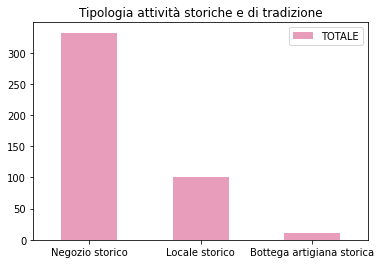

In [7]:
type_df.plot(x = "TIPO", y = "TOTALE", kind = "bar", rot=0, color='#E89EBB')
plt.title("Tipologia attività storiche e di tradizione")
plt.xlabel("");
plt.savefig('type.jpg')

In [8]:
cat_merc_df = df.groupby(by="CAT_MERC")['CAT_MERC'].count().reset_index(name="TOTALE")
cat_merc_df.sort_values('TOTALE', ascending=False, inplace=True)

In [9]:
cat_merc_df

,CAT_MERC,TOTALE
13,Preziosi,73
14,Ristorazione,57
0,Abbigliamento e accessori,53
1,Alimentari e specialità alimentari,48
6,Cartoleria e libreria,34
5,Bar e tabaccheria,30
7,Casa e arredamento,28
17,Sport e tempo libero,25
3,Attrezzature,19
9,"Gelaterie, pasticcerie e torrefazioni",18


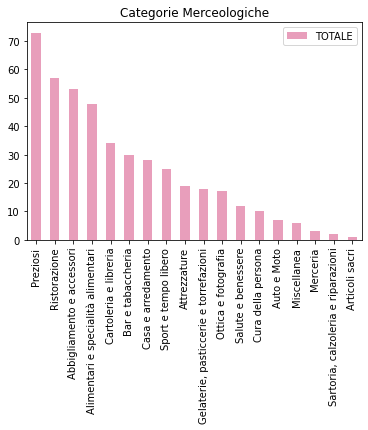

In [10]:
cat_merc_df.plot(x = "CAT_MERC", y = "TOTALE", kind = "bar",  color='#E89EBB')
plt.title("Categorie Merceologiche")
plt.xlabel("");
plt.savefig('cat_merc.jpg')

In [30]:
def centuryFromYear(year):
    return (year + 99) // 100

In [31]:
df['SECOLO'] = centuryFromYear(df['INIZIO_ATT']) 

In [ ]:
year_df = df.groupby(by="INIZIO_ATT")['INIZIO_ATT'].count().reset_index(name="TOTALE")
year_df.sort_values('INIZIO_ATT', ascending=True, inplace=True)

In [35]:
year_df

,INIZIO_ATT,TOTALE
0,1284,1
1,1750,1
2,1768,1
3,1775,1
4,1800,1
...,...,...
106,1978,9
107,1979,3
108,1980,1
109,1981,2


In [33]:
century_df = df.groupby(by="SECOLO")['SECOLO'].count().reset_index(name="TOTALE")
century_df.sort_values('SECOLO', ascending=True, inplace=True)

In [34]:
century_df

,SECOLO,TOTALE
0,13,1
1,18,4
2,19,40
3,20,398


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


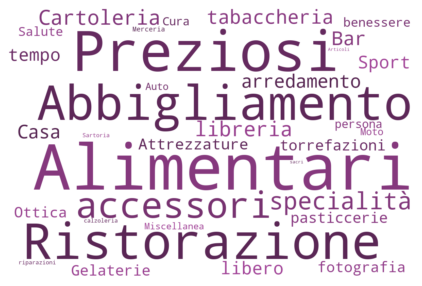

In [11]:

def random_color_func(word, font_size, position, orientation, random_state, **kwargs):
    #h = int(360.0 * 35.0 / 255.0)
    h = int(306)
    s = int(41)
    l = int(100.0 * float(np.random.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

nltk.download('stopwords')
stop_words = set(stopwords.words('italian'))
#mask = np.array(Image.open(f"{base_path}/dati/brain.png"))

wordcloud = WordCloud(width = 1200, height = 800, collocations=False, stopwords=stop_words, background_color="white", mode="RGBA", max_words=1000).generate(' '.join(df['CAT_MERC']))#.generate(str(df['CAT_MERC']))
#wordcloud = WordCloud(width = 1200, height = 800, random_state=1, background_color='white', colormap='Set2',  stopwords = stop_words,mask=mask).generate(' '.join(df['CAT_MERC']))

# create coloring from image
#image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,5])
plt.imshow(wordcloud.recolor(color_func=random_color_func)
          , interpolation="bilinear")
plt.axis("off")
# store to file
plt.savefig("wordCloud_catMerc.png", format="png") 
plt.show()

In [12]:
#df.groupby(by="ZIP")['ZIP'].count()

In [22]:
df[df['INIZIO_ATT'] == df['INIZIO_ATT'].max()]

,ID_NLS,TIPO,RIC,PR,COMUNE,INDIR_ORIG,ZIP,ISTAT,DENOM_IMPRES,INSEGNA,INIZIO_ATT,ANNO_RICONOSCIMENTO,CAT_MERC,geo_y,geo_x
35,3481174,Negozio storico,Storica attività,MI,MILANO,CORSO DI PORTA ROMANA 0006,20122,15146,INCENDIO - SOCIETA' A RESPONSABILITA' LIMITATA...,INCENDIO,1982,2022,Abbigliamento e accessori,45.459864,9.189275
37,3547040,Negozio storico,Storica attività,MI,MILANO,VIA GIUSEPPE COMPAGNONI 0024,20129,15146,MARAZZI GIOVAN BATTISTA,EDICOLA,1982,2022,Cartoleria e libreria,45.465353,9.221624


In [23]:
df[df['INIZIO_ATT'] == df['INIZIO_ATT'].min()]

,ID_NLS,TIPO,RIC,PR,COMUNE,INDIR_ORIG,ZIP,ISTAT,DENOM_IMPRES,INSEGNA,INIZIO_ATT,ANNO_RICONOSCIMENTO,CAT_MERC,geo_y,geo_x
67,6217,Locale storico,Locale storico,MI,MILANO,"Via Vittorini, 4",20138,15146,Bagutto S.r.l.,ANTICA TRATTORIA BAGUTTO,1284,2010,Ristorazione,45.444258,9.260875


In [13]:
import plotly.express as px
import pandas as pd

df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)

color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df, 
                        lat="geo_y", 
                        lon="geo_x", 
                        hover_name="INSEGNA", 
                        hover_data=["INDIR_ORIG"],
                        #color="",
                        color_continuous_scale=color_scale,
                        #size="1",
                        zoom=12, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()